In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('een_api_dataset_5_run.csv', sep=',')

In [23]:
df.shape

(2724, 12)

In [32]:
df.drop('Request ID', axis=1, inplace=True)
df.drop('Test case name', axis=1, inplace=True)
df.drop('Test suite name', axis=1, inplace=True)
#df.reset_index(drop=True, inplace=True)

In [6]:
df.columns

Index(['Endpoint', 'Method', 'Status Code', 'Start time',
       'Duration till headers received[ms]', 'Duration till body received[ms]',
       'Request Body Length', 'Response Body Length', 'Test Result'],
      dtype='object')

In [7]:
df.describe(include='all')

,Endpoint,Method,Status Code,Start time,Duration till headers received[ms],Duration till body received[ms],Request Body Length,Response Body Length,Test Result
count,2724,2724,2724.000000,2724,2724.000000,2724.000000,2724.000000,2724.000000,2724
unique,41,4,NaN,989,NaN,NaN,NaN,NaN,2
top,/g/aaa/authenticate,POST,NaN,2023-03-15 16:14:51,NaN,NaN,NaN,NaN,PASS
freq,438,1454,NaN,14,NaN,NaN,NaN,NaN,2703
mean,NaN,NaN,239.530470,NaN,678.390235,808.573421,137.944567,626.965492,NaN
std,NaN,NaN,80.539561,NaN,2379.699043,3520.783851,237.691782,1168.122817,NaN
min,NaN,NaN,200.000000,NaN,0.000000,7.000000,0.000000,0.000000,NaN
25%,NaN,NaN,200.000000,NaN,59.000000,63.000000,0.000000,24.000000,NaN
50%,NaN,NaN,200.000000,NaN,121.000000,127.000000,49.000000,161.000000,NaN
75%,NaN,NaN,200.000000,NaN,567.000000,580.250000,83.000000,589.000000,NaN


In [8]:
# Max length
df.iloc[df['Duration till body received[ms]'].idxmax()]

Endpoint                              /g/metric/bridgebandwidth
Method                                                      GET
Status Code                                                 200
Start time                                   2023-03-15 0:04:44
Duration till headers received[ms]                        90262
Duration till body received[ms]                           90268
Request Body Length                                           0
Response Body Length                                      10659
Test Result                                                PASS
Name: 1407, dtype: object

# Represent the avg length of time to get a response by endpoint

#### Remove the FAILS from dataframe

In [9]:
df_no_fail = df[df['Test Result'] != 'FAIL'].copy()

In [10]:
grouped = df_no_fail.groupby('Endpoint')['Duration till body received[ms]'].mean()

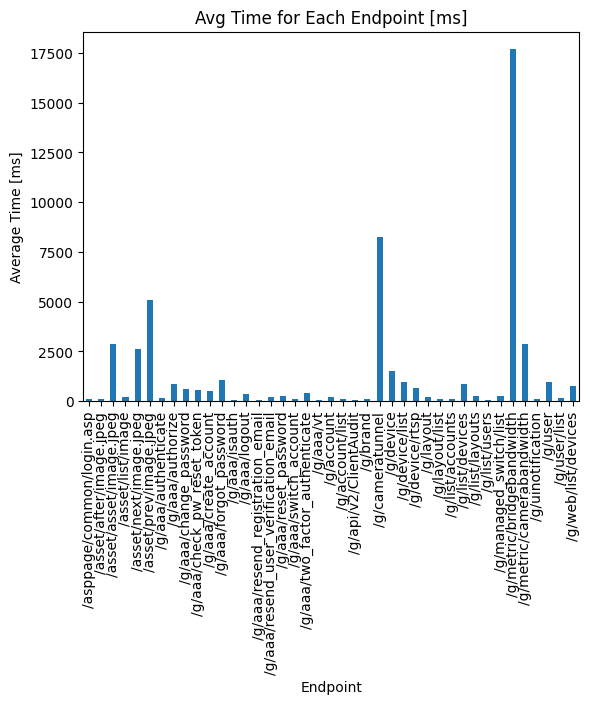

In [11]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Average Time [ms]')
plt.title('Avg Time for Each Endpoint [ms]')
plt.show()

In [61]:
# Does it correlate with size of body response?

In [12]:
grouped = df_no_fail.groupby('Endpoint')['Response Body Length'].mean()

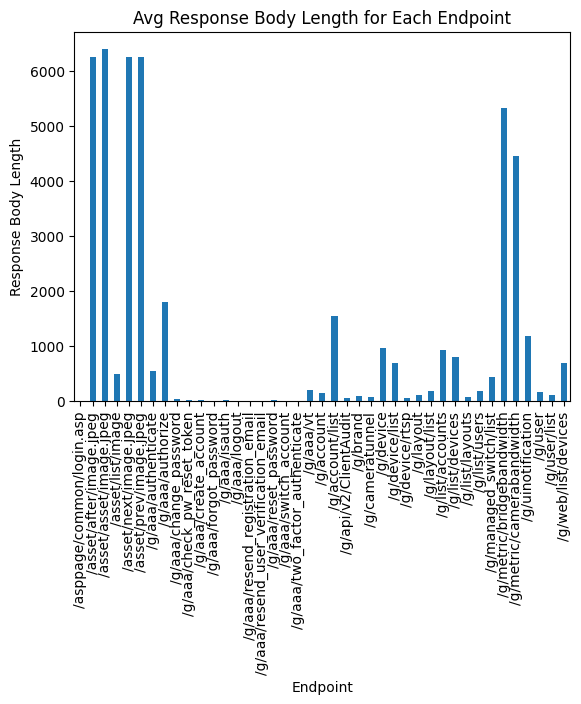

In [13]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Response Body Length')
plt.title('Avg Response Body Length for Each Endpoint')
plt.show()

In [14]:
# Does it correlate? i.e. how useful will APIv3 be on performance?

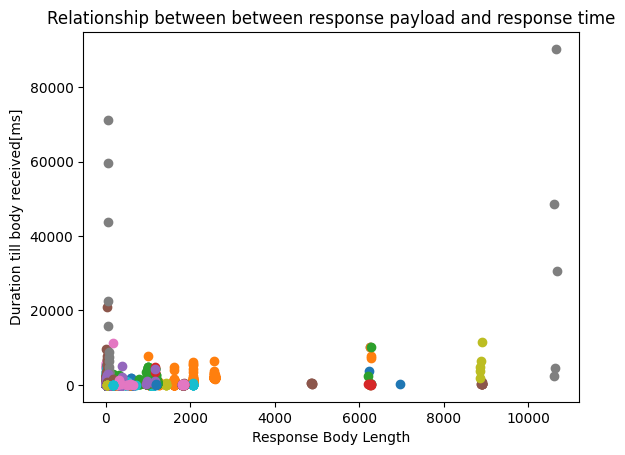

In [14]:
grouped = df_no_fail.groupby(['Endpoint', 'Response Body Length'])['Duration till body received[ms]'].mean()

# create a scatter plot to represent the relationship between response payload and response time
fig, ax = plt.subplots()
for endpoint in df_no_fail['Endpoint'].unique():
    endpoint_df = df_no_fail[df_no_fail['Endpoint'] == endpoint]
    ax.scatter(endpoint_df['Response Body Length'], endpoint_df['Duration till body received[ms]'], label=endpoint)
ax.set_xlabel('Response Body Length')
ax.set_ylabel('Duration till body received[ms]')
ax.set_title('Relationship between between response payload and response time')
#ax.legend()
plt.show()

In [15]:
length_time_df = df_no_fail[['Response Body Length', 'Duration till body received[ms]']]

corr = length_time_df.corr().iloc[0,1]

print('Correlation Coefficient: ', corr)

Correlation Coefficient:  0.2327263757669876


In [ ]:
# What endpoint is Max response time

# Median PASS response and FAIL response

In [16]:
avg_time_by_result = df.groupby('Test Result')['Duration till body received[ms]'].median()
print(avg_time_by_result)

Test Result
FAIL    130.0
PASS    127.0
Name: Duration till body received[ms], dtype: float64


In [49]:
# Group the DataFrame by endpoint and Method, and calculate the median response time for each group
grouped = df.groupby(['Endpoint', 'Method', 'Test Result']).agg({'Duration till body received[ms]': 'median'}).reset_index()

# Filter the grouped DataFrame to include only PASS and FAIL results
grouped_pass = grouped[grouped['Test Result'] == 'PASS']
grouped_fail = grouped[grouped['Test Result'] == 'FAIL']

# Merge the two DataFrames to compare the median response time of PASS and FAIL for each endpoint and Method combination
result = pd.merge(grouped_pass, grouped_fail, on=['Endpoint', 'Method'], suffixes=('_pass', '_fail'))

# Rename the column headers to be more concise
result = result.rename(columns={'Test Result_pass': 'Result', 'Test Result_fail': 'Result','Duration till body received[ms]_pass': 'Pass_median', 'Duration till body received[ms]_fail': 'Fail_median'})
print(result)

              Endpoint Method Result  Pass_median Result  Fail_median
0  /g/aaa/authenticate   POST   PASS         60.0   FAIL         58.0
1     /g/aaa/authorize   POST   PASS        673.0   FAIL        113.0
2        /g/aaa/logout   POST   PASS         82.0   FAIL         64.0
3            /g/device    GET   PASS        160.0   FAIL        645.0
4            /g/device    PUT   PASS       1187.5   FAIL      61261.5
5      /g/list/devices    GET   PASS        323.0   FAIL        127.0


## Avg Time of response every hour

In [38]:
from pytz import timezone

# Convert 'Start time' column to datetime data type
df['Start time'] = pd.to_datetime(df['Start time'])

# Convert the timezone of the datetime object from UTC to CST
df['Start Time'] = df['Start time'].dt.tz_localize('UTC')
df['Start Time'] = df['Start Time'].dt.tz_convert('US/Central')

In [39]:
# Create a new column with the hour value
df['Hour'] = df['Start Time'].dt.hour

# Calculate the mean duration for each hour
hourly_mean_duration = df.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Replace missing duration values with 0
result.fillna(0, inplace=True)

print(result)

    Hour  Duration till body received[ms]
0      0                              0.0
1      1                              0.0
2      2                              0.0
3      3                              0.0
4      4                              0.0
5      5                              0.0
6      6                              0.0
7      7                              0.0
8      8                            135.0
9      9                              0.0
10    10                            123.5
11    11                            122.0
12    12                              0.0
13    13                              0.0
14    14                            129.0
15    15                            133.5
16    16                              0.0
17    17                              0.0
18    18                             97.0
19    19                            125.5
20    20                              0.0
21    21                              0.0
22    22                          